In [ ]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [ ]:
import pandas as pd
#df = pd.read_csv('/content/drive/MyDrive/Semester 7/Machine Learning/Final Report/GOOG.csv', index_col= 'Date')
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Final Report/GOOG.csv', index_col= 'Date')
#drop null value 
df.dropna(inplace=True)

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000
...,...,...,...,...,...,...
2022-11-14,95.500000,97.180000,95.112999,96.029999,96.029999,24170100
2022-11-15,98.669998,100.419998,97.019997,98.720001,98.720001,31831000
2022-11-16,98.019997,99.849998,97.902000,98.989998,98.989998,24660200


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,980.000000,980.000000,980.000000,980.000000,980.000000,9.800000e+02
mean,93.453010,94.506919,92.466048,93.500752,93.500752,3.021579e+07
std,30.995042,31.279238,30.638583,30.934131,30.934131,1.318145e+07
min,50.828499,52.374500,50.676800,50.803001,50.803001,6.936000e+06
25%,63.819749,64.681250,63.306939,64.126749,64.126749,2.185300e+07
50%,87.703251,88.661751,87.013001,87.677750,87.677750,2.708200e+07
75%,119.630247,120.939253,118.189751,119.650123,119.650123,3.416150e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 980 entries, 2019-01-02 to 2022-11-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       980 non-null    float64
 1   High       980 non-null    float64
 2   Low        980 non-null    float64
 3   Close      980 non-null    float64
 4   Adj Close  980 non-null    float64
 5   Volume     980 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 53.6+ KB


Vẽ biểu đồ thể hiện giá cao nhất và thấp nhất trong ngày

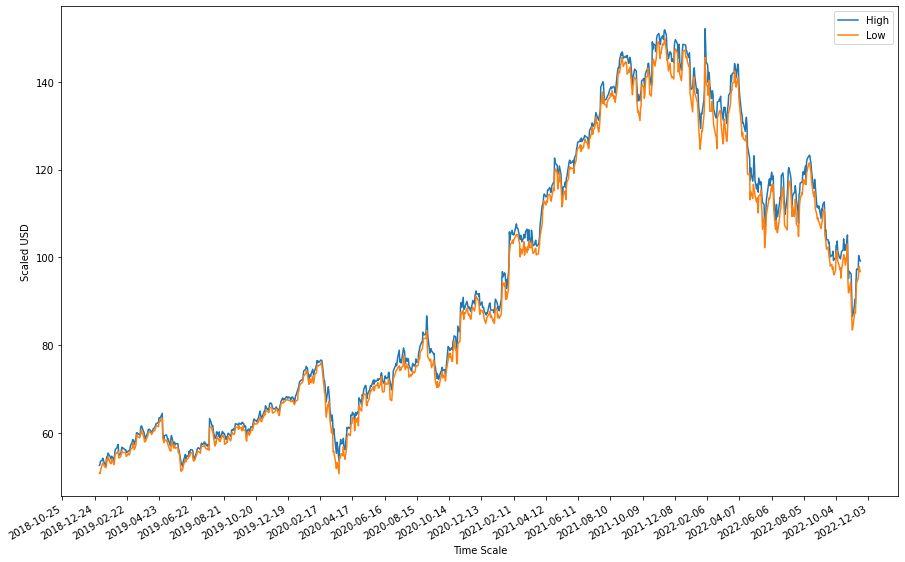

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize = (15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 60))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.index.values]

plt.plot(x_dates, df['High'], label='High')
plt.plot(x_dates, df['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

- Biểu đồ giá mở của và đóng cửa

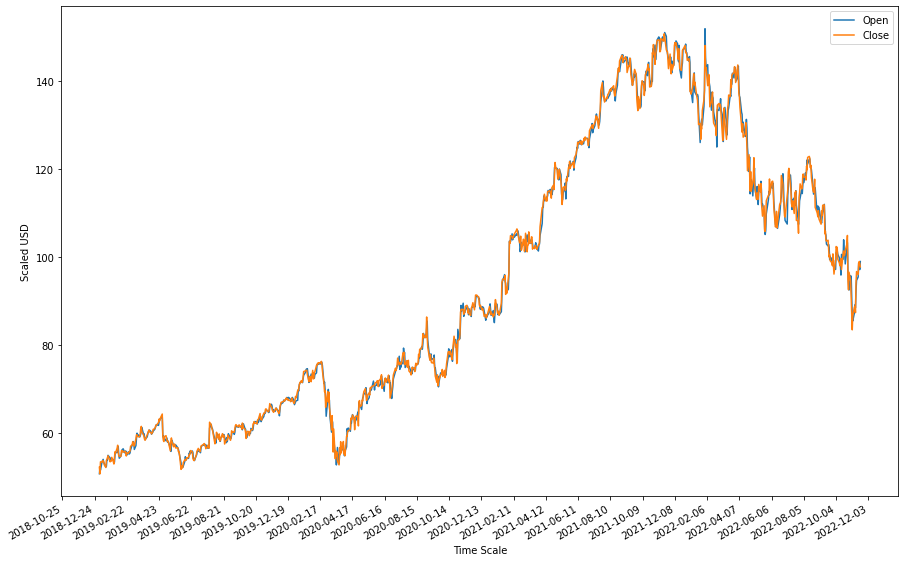

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize = (15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 60))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.index.values]

plt.plot(x_dates, df['Open'], label='Open')
plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
train_df = df.sort_values(by=['Date']).copy()

# Danh sách các tính năng được xem xét
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# tạo data với FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
# them cot 'prediction' de du doan
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2022-11-14,97.180000,95.112999,95.500000,96.029999,24170100,96.029999
2022-11-15,100.419998,97.019997,98.669998,98.720001,31831000,98.720001
2022-11-16,99.849998,97.902000,98.019997,98.989998,24660200,98.989998
2022-11-17,99.480003,97.099998,97.180000,98.500000,21818700,98.500000
2022-11-18,99.160004,96.739998,99.010002,97.800003,24959300,97.800003


In [ ]:
data_filtered

,High,Low,Open,Close,Volume
Date,,,,,
2019-01-02,52.616001,50.785500,50.828499,52.292500,30652000
2019-01-03,52.848999,50.703499,52.049999,50.803001,36822000
2019-01-04,53.542000,51.370899,51.629501,53.535500,41878000
2019-01-07,53.700001,52.737999,53.575001,53.419498,39638000
2019-01-08,54.228001,53.026501,53.805500,53.813999,35298000
...,...,...,...,...,...
2022-11-14,97.180000,95.112999,95.500000,96.029999,24170100
2022-11-15,100.419998,97.019997,98.669998,98.720001,31831000
2022-11-16,99.849998,97.902000,98.019997,98.989998,24660200


- Các biến đầu vào là các biến đưa vào mạng neuron để dự đoán.

- Một nguyên tắc chung là các biến đầu vào phải có giá trị nhỏ, có thể nằm trong khoảng 0-1 hoặc được chuẩn hóa với giá trị trung bình bằng 0 và độ lệch chuẩn (standard deviation) bằng 1. Các biến đầu vào có cần phải scaling hay không phụ thuộc vào từng bài toán cụ thể và từng biến cụ thể.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# transfrom data by scaling (0,1)
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(980, 5)


# xử lý đầu vào dữ liệu với 5 feature, dùng 50 dữ liệu dự đoán

In [ ]:
import math

# Đặt độ dài chuỗi - đây là khung thời gian được sử dụng để đưa ra một dự đoán
sequence_length = 50

# Chỉ số dự đoán

index_Close = data.columns.get_loc("Close")

# Tách dữ liệu đào tạo thành tập dữ liệu đào tạo và đào tạo 
# Bước đầu tiên, chúng tôi lấy số hàng để huấn luyện mô hình trên 80% dữ liệu

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
print(train_data_len)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]

# print(train_data)
test_data = np_data_scaled[train_data_len - sequence_length:, :]
# print("-------",test_data)

# RNN [samples, time steps, features]
# create N samples, sequence_length time steps per sample, and 6 features

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        # print(x)
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training&test
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print("---")
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


784
(734, 50, 5) (734,)
---
(196, 50, 5) (196,)
0.08427921330329724
0.08427921330329724


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
import time

# RNN model
1. Create Model
2. Compile Model
3. Fit the model

In [ ]:
# # Configure the neural network model_rnn
# model_rnn = Sequential()

# # model_rnn with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
# n_neurons = x_train.shape[1] * x_train.shape[2]
# print(n_neurons, x_train.shape[1], x_train.shape[2])
# model_rnn.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
# model_rnn.add(LSTM(n_neurons, return_sequences=False))
# model_rnn.add(Dense(5))
# model_rnn.add(Dense(1))

# # Compile the model_rnn
# model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
# # Build the LSTM model

# model_rnn = Sequential()

# # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
# # n_neurons = x_train.shape[1] * x_train.shape[2]

# model_rnn.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
# model_rnn.add(LSTM(64, return_sequences=False))
# model_rnn.add(Dense(25))
# model_rnn.add(Dense(1))

# # Compile the model
# model_rnn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Configure the neural network model_rnn
model_rnn = Sequential()



# model_rnn with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]


model_rnn.add(SimpleRNN(n_neurons, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model_rnn.add(SimpleRNN(n_neurons, return_sequences = False))

model_rnn.add(Dense(5))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')


- fit model

In [ ]:
epochs = 50
batch_size = 16

#testing Time
StartTime=time.time()
history = model_rnn.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
EndTime=time.time()

print("############### Total Time Taken: ", EndTime-StartTime, 's #############')

# model_rnn.fit(x_train,y_train,epochs = 5, batch_size = 32)

Epoch 1/50
46/46 [==============================] - 6s 81ms/step - loss: 0.3871 - val_loss: 0.0154
Epoch 2/50
46/46 [==============================] - 3s 74ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 3/50
46/46 [==============================] - 3s 74ms/step - loss: 0.0070 - val_loss: 0.0094
Epoch 4/50
46/46 [==============================] - 4s 88ms/step - loss: 0.0097 - val_loss: 0.0015
Epoch 5/50
46/46 [==============================] - 6s 141ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 6/50
46/46 [==============================] - 4s 90ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/50
46/46 [==============================] - 3s 72ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 8/50
46/46 [==============================] - 3s 73ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/50
46/46 [==============================] - 3s 72ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/50
46/46 [==============================] - 3s 71ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11

Biểu đồ độ loss

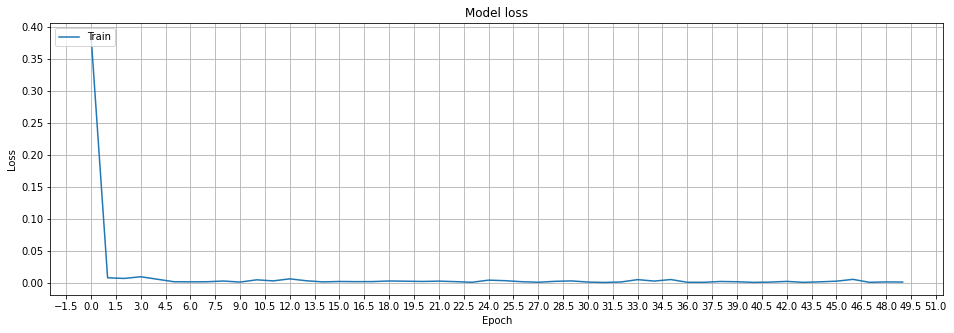

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

- Đo độ chính xác model.

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predicted values
StartTime=time.time()
y_pred_scaled = model_rnn.predict(x_test)
EndTime=time.time()

print("############### Total Time Taken: ",EndTime-StartTime, 's #############')

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Acurracy score
# print(y_test_unscaled)
# print(y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


7/7 [==============================] - 1s 33ms/step
############### Total Time Taken:  0.6231701374053955 s #############
Median Absolute Error (MAE): 7.04
Mean Absolute Percentage Error (MAPE): 6.21 %
Median Absolute Percentage Error (MDAPE): 6.04 %


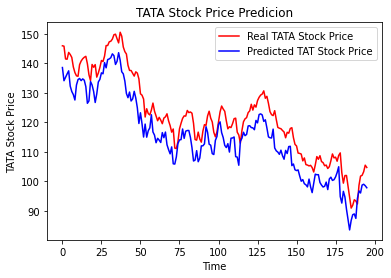

In [ ]:
plt.plot(y_pred, color = 'red',label = 'Real TATA Stock Price')
plt.plot(y_test_unscaled, color= 'blue',label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Predicion')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

# Overfitting RNN model

In [ ]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
StartTime=time.time()
history = model_rnn.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop]
                   )
EndTime=time.time()

print("############### Total Time Taken: ",EndTime-StartTime, 's #############')


Epoch 1/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/50
46/46 [==============================] - 3s 76ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 3/50
46/46 [==============================] - 4s 80ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/50
46/46 [==============================] - 4s 78ms/step - loss: 9.0801e-04 - val_loss: 0.0011
Epoch 5/50
46/46 [==============================] - 4s 78ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 6/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/50
46/46 [==============================] - 3s 76ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/50
46/46 [==============================] - 3s 76ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/50
46/46 [==============================] - 4s 76ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 9: early stopping
############### Total Time Taken:  32.17490100860596 s #############


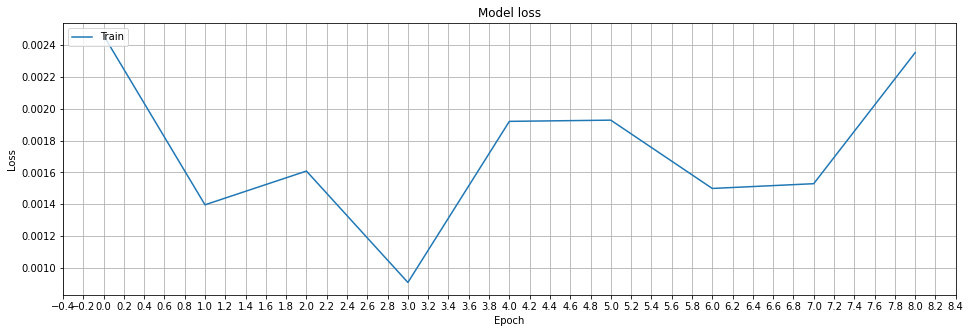

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

- Độ chính xác sau khi overfitting

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predicted values
y_pred_scaled = model_rnn.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Acurracy score
# print(y_test_unscaled)
# print(y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R Squared (R2): {np.round(R2, 2)}')

7/7 [==============================] - 0s 32ms/step
Median Absolute Error (MAE): 8.48
Mean Absolute Percentage Error (MAPE): 7.51 %
Median Absolute Percentage Error (MDAPE): 7.6 %
R Squared (R2): 0.57


In [ ]:
# score = model_rnn.evaluate(x_test, y_test,  batch_size=128)
# print(score)

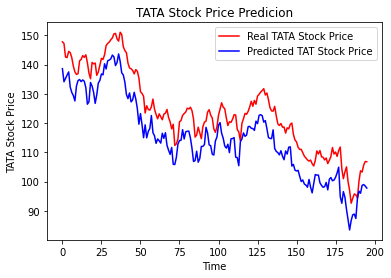

In [ ]:
plt.plot(y_pred, color = 'red',label = 'Real TATA Stock Price')
plt.plot(y_test_unscaled, color= 'blue',label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Predicion')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

# Multi Layer Perceptrons

In [ ]:
# MLP 
model_MLP = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = (50,5)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

In [ ]:
#MLPs compile model
model_MLP.compile(optimizer='adam',
              loss='mae')

In [ ]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model_MLP.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/50
46/46 [==============================] - 1s 7ms/step - loss: 0.1333 - val_loss: 0.1070
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0836 - val_loss: 0.0715
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0591 - val_loss: 0.0576
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0545 - val_loss: 0.0473
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0572 - val_loss: 0.0441
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0511 - val_loss: 0.0472
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0505 - val_loss: 0.0439
Epoch 8/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0843
Epoch 9/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0472 - val_loss: 0.0521
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0486 - val_loss: 0.0546
Epoch 11/50
46/46 [

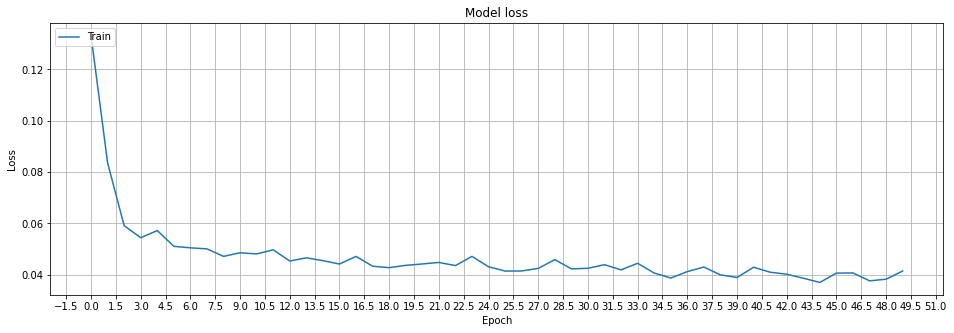

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values
y_pred_scaled = model_MLP.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Acurracy score
# print(y_test_unscaled)
# print(y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


7/7 [==============================] - 0s 3ms/step
Median Absolute Error (MAE): 3.88
Mean Absolute Percentage Error (MAPE): 3.46 %
Median Absolute Percentage Error (MDAPE): 3.19 %


OVERFITTING FOR MLP.

In [ ]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model_MLP.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop]
                   )

Epoch 1/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0390 - val_loss: 0.0443
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0380
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0365 - val_loss: 0.0442
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0388 - val_loss: 0.0372
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0372
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0382 - val_loss: 0.0552
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0411 - val_loss: 0.0371
Epoch 8/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0376 - val_loss: 0.0424
Epoch 8: early stopping


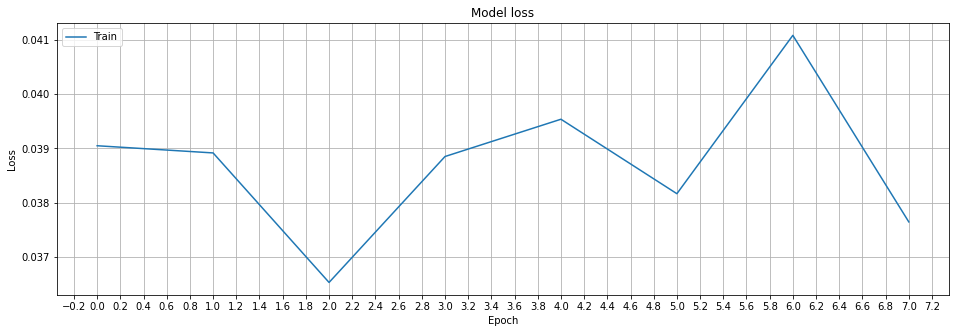

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
print(x_test)

[[[0.94513428 0.9211627  0.93652458 0.91735227 0.2956725 ]
  [0.94383724 0.91545774 0.92427375 0.90900442 0.18378212]
  [0.9255456  0.91023647 0.90063354 0.93060982 0.12212894]
  ...
  [0.91723773 0.88722494 0.91929039 0.88217929 0.32143954]
  [0.87703337 0.86881963 0.87259624 0.8849318  0.23309785]
  [0.90048184 0.90413838 0.89099076 0.90735294 0.18507901]]

 [[0.94383724 0.91545774 0.92427375 0.90900442 0.18378212]
  [0.9255456  0.91023647 0.90063354 0.93060982 0.12212894]
  [0.93094035 0.91192983 0.92707481 0.91803788 0.16852667]
  ...
  [0.87703337 0.86881963 0.87259624 0.8849318  0.23309785]
  [0.90048184 0.90413838 0.89099076 0.90735294 0.18507901]
  [0.89301628 0.88068329 0.87763156 0.87882102 0.22253507]]

 [[0.9255456  0.91023647 0.90063354 0.93060982 0.12212894]
  [0.93094035 0.91192983 0.92707481 0.91803788 0.16852667]
  [0.92230167 0.9068599  0.91795427 0.9308099  0.1302174 ]
  ...
  [0.90048184 0.90413838 0.89099076 0.90735294 0.18507901]
  [0.89301628 0.88068329 0.8776315

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predicted values
y_pred_scaled = model_MLP.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Acurracy score
# print(y_test_unscaled)
# print(y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R Squared (R2): {np.round(R2, 2)}')

7/7 [==============================] - 0s 3ms/step
Median Absolute Error (MAE): 4.23
Mean Absolute Percentage Error (MAPE): 3.59 %
Median Absolute Percentage Error (MDAPE): 2.98 %
R Squared (R2): 0.85


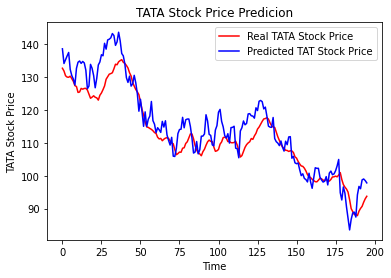

In [ ]:
plt.plot(y_pred, color = 'red',label = 'Real TATA Stock Price')
plt.plot(y_test_unscaled, color= 'blue',label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Predicion')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

# LSTM model

In [ ]:
# Configure the neural network model
model_LSTM = Sequential()

# Model_LSTM with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model_LSTM.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model_LSTM.add(LSTM(n_neurons, return_sequences=False))
model_LSTM.add(Dense(5))
model_LSTM.add(Dense(1))

# Compile the model_LSTM
model_LSTM.compile(optimizer='adam', loss='mse')

250 50 5


In [ ]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)


StartTime=time.time()
history = model_LSTM.fit(x_train, y_train, 
                   batch_size=batch_size, 
                   epochs=epochs,
                   validation_data=(x_test, y_test), 
                   callbacks=[early_stop])
EndTime=time.time()

print("############### Total Time Taken: ",EndTime-StartTime, 's #############')



Epoch 1/50
46/46 [==============================] - 19s 329ms/step - loss: 0.0219 - val_loss: 0.0049
Epoch 2/50
46/46 [==============================] - 14s 300ms/step - loss: 8.9322e-04 - val_loss: 0.0028
Epoch 3/50
46/46 [==============================] - 14s 302ms/step - loss: 7.4381e-04 - val_loss: 0.0032
Epoch 4/50
46/46 [==============================] - 14s 301ms/step - loss: 7.5339e-04 - val_loss: 0.0041
Epoch 5/50
46/46 [==============================] - 14s 306ms/step - loss: 7.3986e-04 - val_loss: 0.0027
Epoch 6/50
46/46 [==============================] - 14s 307ms/step - loss: 7.0563e-04 - val_loss: 0.0024
Epoch 7/50
46/46 [==============================] - 14s 302ms/step - loss: 6.6916e-04 - val_loss: 0.0025
Epoch 8/50
46/46 [==============================] - 14s 299ms/step - loss: 6.6205e-04 - val_loss: 0.0019
Epoch 9/50
46/46 [==============================] - 14s 310ms/step - loss: 7.1310e-04 - val_loss: 0.0020
Epoch 10/50
46/46 [==============================] - 15s 32

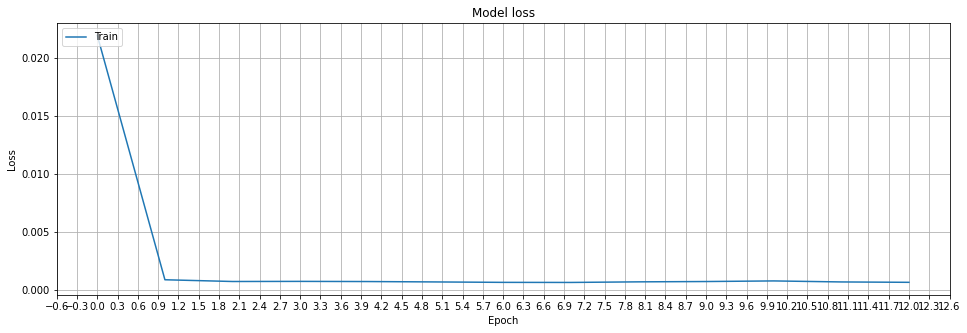

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predicted values
y_pred_scaled = model_LSTM.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

#Acurracy score
# print(y_test_unscaled)
# print(y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R Squared (R2): {np.round(R2, 2)}')

7/7 [==============================] - 2s 111ms/step
Median Absolute Error (MAE): 3.67
Mean Absolute Percentage Error (MAPE): 3.25 %
Median Absolute Percentage Error (MDAPE): 3.0 %
R Squared (R2): 0.9


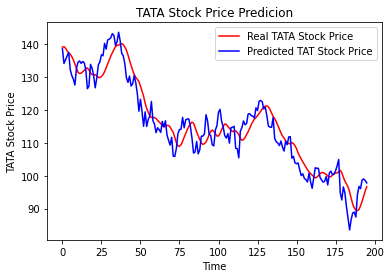

In [ ]:
plt.plot(y_pred, color = 'red',label = 'Real TATA Stock Price')
plt.plot(y_test_unscaled, color= 'blue',label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Predicion')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

# Predict Next 14 day

In [ ]:
from numpy import array
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta

----

In [ ]:
# Create a new dataframe with only the 'Close column 
LSTM_temp = df_Close
# Convert the dataframe to a numpy array
dataset = LSTM_temp.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 )) #We use 80% traing and 20% test - this means it predicts from 2019 in july.

training_data_len

784

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.014909  , 0.        , 0.0273507 , 0.02618959, 0.03013831,
       0.02932758, 0.02716051, 0.02058435, 0.01432847, 0.03057371,
       0.03248553, 0.03695472, 0.04113864, 0.02725562, 0.02978299,
       0.0289472 , 0.03750024, 0.02703542, 0.02230093, 0.03653432,
       0.05020219, 0.04738952, 0.0584249 , 0.06502612, 0.04963165,
       0.04136388, 0.03953714, 0.03951213, 0.05270454, 0.05209895,
       0.05285467, 0.04884089, 0.05129822, 0.04891596, 0.04049304,
       0.04719937, 0.04671391, 0.0495816 , 0.05004205, 0.05197883,
       0.06252376, 0.06593196, 0.07305367, 0.07096672, 0.06367986,
       0.0631894 , 0.0799251 , 0.08865333, 0.08871338, 0.08482473,
       0.08427921, 0.08417913, 0.09148099, 0.10405282, 0.10784136,
       0.09480913, 0.08855325, 0.08435928, 0.07855384, 0.0762867 ])]
[0.07869897782614632]

[array([0.014909  , 0.        , 0.0273507 , 0.02618959, 0.03013831,
       0.02932758, 0.02716051, 0.02058435, 0.01432847, 0.03057371,
       0.03248553, 0.03695472, 0.04

In [ ]:
# Configure the neural network model_rnn
model_rnn = Sequential()



# model_rnn with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]


model_rnn.add(SimpleRNN(n_neurons, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model_rnn.add(SimpleRNN(n_neurons, return_sequences = False))

model_rnn.add(Dense(5))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
history = model_rnn.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_split=0.2)

Epoch 1/40
19/19 [==============================] - 3s 52ms/step - loss: 0.0411 - val_loss: 0.0029
Epoch 2/40
19/19 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 3/40
19/19 [==============================] - 1s 33ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/40
19/19 [==============================] - 1s 33ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/40
19/19 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 6/40
19/19 [==============================] - 1s 34ms/step - loss: 8.9703e-04 - val_loss: 0.0031
Epoch 7/40
19/19 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/40
19/19 [==============================] - 1s 32ms/step - loss: 7.8084e-04 - val_loss: 0.0015
Epoch 9/40
19/19 [==============================] - 1s 32ms/step - loss: 6.0373e-04 - val_loss: 0.0016
Epoch 10/40
19/19 [==============================] - 1s 32ms/step - loss: 6.3402e-04 - val_loss: 

In [ ]:
X_predict = df_Close[-60:].values.reshape(-1, 1)
X_predict = scaler.transform(X_predict)
y_pred_new = []
for i in range(14):
  new_X = X_predict[-60:].reshape(1, 60, 1)
  new_pred = model_rnn.predict(new_X)
  X_predict = np.concatenate((X_predict, new_pred), axis=0)
  y_pred_new.append(new_pred[0])
y_pred_new = np.array(y_pred_new)

1/1 [==============================] - 0s 23ms/step


[ 99.350334  99.37552  100.62011  100.63118  101.798645 102.90748
 103.242165 103.34599  105.51014  105.96592  105.52357  106.55315
 107.83512  107.75218 ]


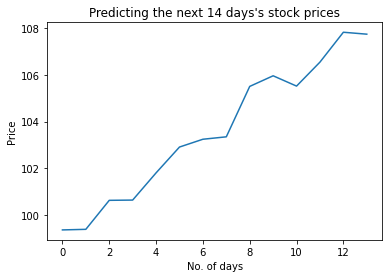

In [ ]:
y_pred_inv = scaler.inverse_transform(y_pred_new).reshape(-1,)
print(y_pred_inv)

#Vẽ đồ thị dự đoán 14 ngày tiếp theo

plt.plot(y_pred_inv)
plt.xlabel('No. of days')
plt.ylabel('Price')
plt.title("Predicting the next 14 days's stock prices")
plt.show()

In [ ]:
# MLP 
model_MLP = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = (60,1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

In [ ]:
model_MLP.compile(optimizer='adam',
              loss='mae')

In [ ]:
history = model_MLP.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_split=0.2)

Epoch 1/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0268 - val_loss: 0.0651
Epoch 2/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0626
Epoch 3/40
19/19 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0268
Epoch 4/40
19/19 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0264
Epoch 5/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0229 - val_loss: 0.0597
Epoch 6/40
19/19 [==============================] - 0s 5ms/step - loss: 0.0232 - val_loss: 0.0311
Epoch 7/40
19/19 [==============================] - 0s 5ms/step - loss: 0.0236 - val_loss: 0.0406
Epoch 8/40
19/19 [==============================] - 0s 5ms/step - loss: 0.0232 - val_loss: 0.0537
Epoch 9/40
19/19 [==============================] - 0s 5ms/step - loss: 0.0260 - val_loss: 0.0277
Epoch 10/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0240 - val_loss: 0.0317
Epoch 11/40
19/19 [

In [ ]:
X_predict = df_Close[-60:].values.reshape(-1, 1)
X_predict = scaler.transform(X_predict)
y_pred_new = []
for i in range(14):
  new_X = X_predict[-60:].reshape(1, 60, 1)
  new_pred = model_MLP.predict(new_X)
  X_predict = np.concatenate((X_predict, new_pred), axis=0)
  y_pred_new.append(new_pred[0])
y_pred_new = np.array(y_pred_new)

1/1 [==============================] - 0s 102ms/step


[100.52777  101.67822  103.2686   103.1166   103.51648  103.62336
 104.9844   106.49684  106.389465 106.41586  106.46415  107.737854
 108.192924 106.64444 ]


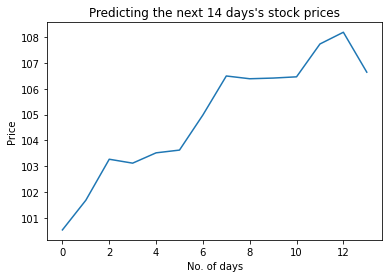

In [ ]:
y_pred_inv = scaler.inverse_transform(y_pred_new).reshape(-1,)
print(y_pred_inv)

#Vẽ đồ thị dự đoán 14 ngày tiếp theo

plt.plot(y_pred_inv)
plt.xlabel('No. of days')
plt.ylabel('Price')
plt.title("Predicting the next 14 days's stock prices")
plt.show()